In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt

import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import gensim

# Чтение данных и удаление пустых значений
df = pd.read_csv('FakeNewsNet.csv', encoding='utf-8', usecols=['title', 'news_url', 'source_domain', 'real'])
df = df.dropna(how='any', axis=0)
print(f'Cтрок после удаления: {df.shape[0]}')

# Проверка дисбаланса данных
print(df.real.value_counts())

C:\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cтрок после удаления: 22866
1    17371
0     5495
Name: real, dtype: int64


In [3]:
df['text'] = df.apply(lambda x: x['title']+'; '+x['news_url']+'; '+x['source_domain'], axis=1)
df.head(5)

,title,news_url,source_domain,real,text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1,Kandi Burruss Explodes Over Rape Accusation on...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1,People's Choice Awards 2018: The best red carp...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1,Colombian singer Maluma sparks rumours of inap...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22866 entries, 0 to 23195
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          22866 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   real           22866 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 893.2+ KB


In [4]:
# Определите поля (fields)
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
# Создайте список примеров
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
# Создайте Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
# Задайте seed для воспроизводимости
SEED = 42
random.seed(SEED)

# Разбейте на тренировочный и тестовый наборы данных
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [ ]:
# Построение словаря
TEXT.build_vocab(train_data)
LABEL.build_vocab(train_data)

In [ ]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text))

In [ ]:
#
documents = df['text'].tolist()
w2v_model = gensim.models.word2vec.Word2Vec(sentences=documents,vector_size=150,sg=0, window=10,min_count=2,workers=10)
w2v_model.build_vocab(documents, progress_per=10000)
w2v_model.train(documents,total_examples=len(documents),epochs=10)
w2v_model.save('w2v_model.txt')
# w2v_model = gensim.models.word2vec.Word2Vec.load('...txt')

pre_trained_emb = torch.FloatTensor(w2v_model.wv.vectors)
embedding = nn.Embedding.from_pretrained(pre_trained_emb)

#### С этого момента мне не понятно, как использовать обученную модель Word2Vec, так же не понимаю, как использовать полученные ранее объекты TEXT и LABEL
(код ниже пока без изменений, взят с практики 6.6 для pytorch)

In [13]:
# Определяем модель
class AttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden.squeeze(0))

In [14]:
# Определяем параметры модели
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
OUTPUT_DIM = 1
N_LAYERS = 1
DROPOUT = 0.5

In [15]:
model = AttentionModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

C:\Python310\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [17]:
model = model.to(device)
criterion = criterion.to(device)

In [18]:
# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [19]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()

In [20]:
N_EPOCHS = 10

In [21]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


 10%|██████████▋                                                                                                | 1/10 [00:05<00:49,  5.53s/it]

Epoch: 01, Train Loss: 0.514, Train Acc: 78.22%, Val Loss: 0.514, Val Acc: 78.22%


 20%|█████████████████████▍                                                                                     | 2/10 [00:09<00:37,  4.73s/it]

Epoch: 02, Train Loss: 0.427, Train Acc: 82.39%, Val Loss: 0.427, Val Acc: 82.38%


 30%|████████████████████████████████                                                                           | 3/10 [00:13<00:31,  4.48s/it]

Epoch: 03, Train Loss: 0.376, Train Acc: 84.55%, Val Loss: 0.376, Val Acc: 84.55%


 40%|██████████████████████████████████████████▊                                                                | 4/10 [00:18<00:26,  4.38s/it]

Epoch: 04, Train Loss: 0.342, Train Acc: 86.03%, Val Loss: 0.342, Val Acc: 86.03%


 50%|█████████████████████████████████████████████████████▌                                                     | 5/10 [00:22<00:21,  4.30s/it]

Epoch: 05, Train Loss: 0.311, Train Acc: 87.26%, Val Loss: 0.311, Val Acc: 87.26%


 60%|████████████████████████████████████████████████████████████████▏                                          | 6/10 [00:26<00:16,  4.25s/it]

Epoch: 06, Train Loss: 0.291, Train Acc: 88.28%, Val Loss: 0.291, Val Acc: 88.28%


 70%|██████████████████████████████████████████████████████████████████████████▉                                | 7/10 [00:30<00:12,  4.19s/it]

Epoch: 07, Train Loss: 0.268, Train Acc: 89.24%, Val Loss: 0.268, Val Acc: 89.24%


 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 8/10 [00:34<00:08,  4.17s/it]

Epoch: 08, Train Loss: 0.247, Train Acc: 90.09%, Val Loss: 0.247, Val Acc: 90.09%


 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9/10 [00:38<00:04,  4.16s/it]

Epoch: 09, Train Loss: 0.226, Train Acc: 90.99%, Val Loss: 0.226, Val Acc: 90.99%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.29s/it]

Epoch: 10, Train Loss: 0.211, Train Acc: 91.82%, Val Loss: 0.210, Val Acc: 91.82%


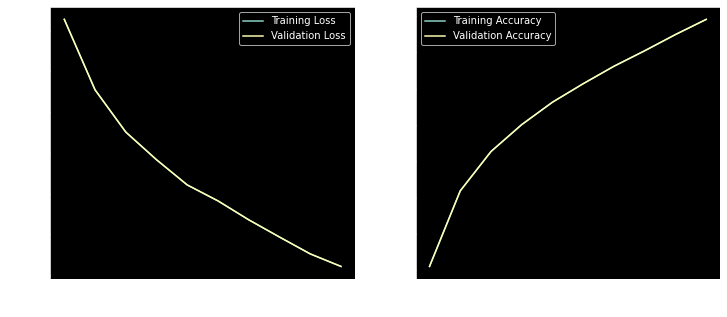

In [22]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Сохранение модели
# torch.save(model.state_dict(), 'model_pytorch.pt' )

In [23]:
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:01<00:00, 142.75it/s]


Accuracy: 0.8578613601574459
F1 Score: 0.6194379391100703
ROC AUC Score: 0.8595447456597167


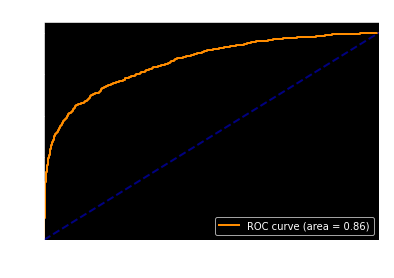

In [24]:
evaluate_model(model, test_iterator)